# STM32 Readout

In [1]:
from collections import deque
from datetime import datetime, timedelta
import glob
import time
import warnings

from IPython import display
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import serial
import serial.tools.list_ports

### Port selection

In [2]:
[str(x) for x in serial.tools.list_ports.comports()]

['/dev/ttyACM0 - STLINK-V3 - ST-Link VCP Ctrl']

In [3]:
# To change the baud rate, you must also change it in the C code.
# On Jelle's linux laptop, baud rates above 2_000_000 do not help;
#    (apparently linux has a 4096-byte serial buffer that's filling 
#     faster than we can read it out here (even in a separate thread).
# On windows you might be able to adjust the buffer size and go higher.
ser = serial.Serial(
    port='/dev/ttyACM0',
    baudrate=2_000_000, 
    timeout=4)

### Readout functions

In [4]:
SAMPLES_IN_EVENT = 1000

# All below lengths are in bytes:
BYTES_PER_SAMPLE = 2
DATA_LENGTH = BYTES_PER_SAMPLE * SAMPLES_IN_EVENT
FOOTER_LENGTH = 32
PACKET_LENGTH = FOOTER_LENGTH + DATA_LENGTH

MAGIC_TERMINATOR = b'!~O_o~!\0'


packets_read = 0

def read_packet(ser):
    """Read one event 'packet' from the serial port
        Returns (raw packet blob, dict with metadata)
    """
    global packets_read
    n_waiting = ser.inWaiting()
    # if n_waiting > 4000 and packets_read > 10:
    #     warnings.warn(
    #         f"{ser.inWaiting()} bytes buffered: not keeping up!",
    #         UserWarning)
    
    # Read from the serial buffer until we get exactly
    # a packet's worth of data.
    n_reads = 0
    packet = b''
    while len(packet) != PACKET_LENGTH:
        packet = ser.read_until(MAGIC_TERMINATOR)
        n_reads += 1
    packets_read += 1

    return (
        packet,
        dict(bytes_waiting=n_waiting,
             bad_reads=n_reads - 1, 
             packets_read=packets_read))


def decode_packet(blob, **kwargs):
    """Return (data_array, metadata_dict) from blob of packet bytes"""
    data, footer = blob[:DATA_LENGTH], blob[DATA_LENGTH:]

    event_number = np.frombuffer(footer[:4], dtype=np.uint32).item()
    fifo_slot = footer[4]
    timestamp = datetime.strptime(footer[5:24].decode(), 
                                  '%y%m%d_%H:%M:%S.%f')
    dt = (timestamp - datetime(2000, 1, 1)).total_seconds()
    
    metadata = dict(
        event_number=event_number, 
        fifo_slot=fifo_slot, 
        t=dt,
        **kwargs)
    data = np.frombuffer(data, dtype=np.uint16)
    return data, metadata


def save_data(filename, waveforms, metadata):
    """Save waveforms and metadata to filename as .npz
    
    Args:
     - filename: path (with or without .npz suffix)
     - waveforms: array or list of arrays
     - metadata: dataframe or list of dicts
    """
    if isinstance(waveforms, list):
        waveforms = np.stack(waveforms)
    if isinstance(metadata, list):
        metadata = pd.DataFrame(metadata)
    np.savez(
        filename,
        waveforms=waveforms,
        metadata=metadata.to_records(index=False))


def load_data(filename):
    """Load (waveforms array, metadata DataFrame) from filename
    """
    if not filename.endswith('.npz'):
        filename += '.npz'
    q = np.load(filename)
    return q['waveforms'], pd.DataFrame.from_records(q['metadata'])


def load_all(output_name):
    """Load and concatenate all data under output_name"""
    wvs, meta = zip(*[
        load_data(filename)
        for filename  in sorted(glob.glob(output_name + '*.npz'))])
    return np.concatenate(wvs), pd.concat(meta).reset_index()

## Readout configuration

In [5]:
# Stop acquisition after this many events.
acquire_n = 1_000

# Save every ... events to a different file
events_per_file = acquire_n

# Output filename
# Data will be saved to output_name_XXXXXX.npz,
# where XXX is the file number
output_name = 'test'

# Make a plot, but only as often as plot_seconds
# (plotting every event can slow acquisition)
make_plot = True
plot_seconds = 1.

### Readout loop

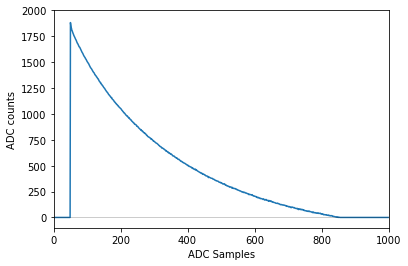

Good events:   0%|          | 0/1000 [00:00<?, ?it/s]

Missed events: 0it [00:00, ?it/s]

Bad reads (likely PC-side buffer full): 0it [00:00, ?it/s]

Warmup to empty buffer:   0%|          | 0/10 [00:00<?, ?it/s]

Acquisition took 26.86 sec 


In [6]:
if make_plot:
    fig = plt.figure(figsize=(6,4))
    hfig = display.display(fig, display_id=True)
    x = np.arange(SAMPLES_IN_EVENT)
    line, = plt.plot(x, float('nan') * x)
    plt.axhline(0, linewidth=1, c='k', alpha=0.2)
    plt.xlim(0, SAMPLES_IN_EVENT)
    plt.xlabel("ADC Samples")
    plt.ylabel("ADC counts")
    plt.ylim(-100, 2000)
    
good_counter = tqdm(total=acquire_n, desc='Good events')
missed_counter = tqdm(desc='Missed events')
bad_read_counter = tqdm(desc='Bad reads (likely PC-side buffer full)')
file_number = 0

waveforms = []
metadata = []
corrupted_packets = deque(maxlen=10)   # For debugging
last_event_number = None
done = False

# Empty the PC-side serial buffer
ser.read(ser.inWaiting())
# Try to empty the fifo buffer on the microcontroller
# (otherwise first few events are way earlier than others)
for _ in tqdm(range(10), "Warmup to empty buffer"):
    read_packet(ser);

t_start = datetime.now()
last_plot = datetime(year=2000, month=1, day=1)

while not done:
    try:
        while not done and len(waveforms) < events_per_file:

            # Read, decode, and store
            packet, packet_meta = read_packet(ser)
            waveform, meta = decode_packet(packet, **packet_meta)
            waveforms.append(waveform)
            metadata.append(meta)

            # Update counters
            good_counter.update()
            done = good_counter.n >= acquire_n
            bad_read_counter.update(meta['bad_reads'])

            # Track missing events
            if last_event_number is not None:
                event_diff = meta['event_number'] - (last_event_number + 1)
                missed_counter.update(event_diff)
            last_event_number = meta['event_number']

            # Plot if needed
            next_plot = last_plot + timedelta(seconds=plot_seconds)
            if make_plot and datetime.now() > next_plot:
                line.set_data(np.arange(len(waveform)), waveform)
                hfig.update(fig)
                last_plot = datetime.now()

    except KeyBoardInterrupt:
        # That's fine, end acquisition.
        # 'finally' below will save current chunk.
        print("Acquisition interrupted.")
        break
                
    finally:
        # Save chunk of data to file
        save_data(output_name + ('%06d' % file_number),
                  waveforms,
                  metadata)
        waveforms.clear()
        metadata.clear()
        file_number += 1

if make_plot:
    plt.close();
dt = datetime.now() - t_start
print(f"Acquisition took {dt.total_seconds():.2f} sec ")

metadata = pd.DataFrame(metadata)

### Analysis demo

In [7]:
from multihist import Histdd, Hist1d

In [8]:
waveforms, meta = load_all(output_name)

In [9]:
n_samples = waveforms.shape[1]
n_baseline = 10

baseline = waveforms[:, :n_baseline]
meta['baseline'] = baseline.mean(axis=1)
meta['baseline_std'] = baseline.std(axis=1)
meta['max_sample'] = np.argmax(waveforms, axis=1)
meta['height'] = np.max(waveforms, axis=1) - meta['baseline']
meta['area'] = np.sum(waveforms, axis=1) - n_samples * meta['baseline']
meta.tail()

,index,event_number,fifo_slot,t,bytes_waiting,bad_reads,packets_read,baseline,baseline_std,max_sample,height,area
995,995,5123,0,132.385,0,0,1006,0.0,0.0,50,1927.0,448515.0
996,996,5124,0,132.412,0,0,1007,0.0,0.0,50,1884.0,450441.0
997,997,5125,0,132.436,0,0,1008,0.0,0.0,50,1885.0,441855.0
998,998,5126,0,132.463,0,0,1009,0.0,0.0,50,1925.0,454397.0
999,999,5127,0,132.491,0,0,1010,0.0,0.0,50,1889.0,441482.0


Text(0, 0.5, 'Events / bin')

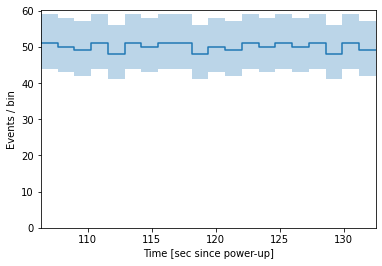

In [10]:
t_spectrum = Hist1d(
   meta['t'], 
   bins=20)
t_spectrum.plot(errors=True, error_style='band', set_xlim=True)
plt.ylim(0, None)
plt.xlabel("Time [sec since power-up]")
plt.ylabel("Events / bin")

Text(0, 0.5, 'Waveforms / bin')

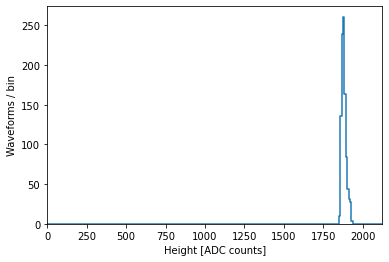

In [11]:
height_spectrum = Hist1d(
   meta['height'], 
   bins=np.linspace(0, meta['height'].max() * 1.1, 250))
height_spectrum.plot(set_xlim=True)
plt.ylim(0, None)
plt.xlabel("Height [ADC counts]")
plt.ylabel("Waveforms / bin")

Text(0, 0.5, 'Amplitude [ADC counts]')

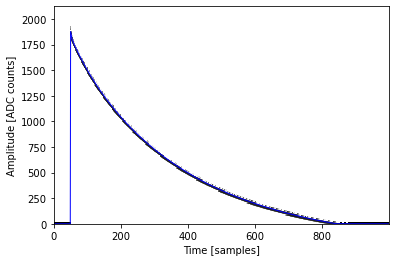

In [12]:
# Plot median waveform in blue
n_samples = waveforms.shape[1]
median = np.median(waveforms, axis=0)
t = np.arange(n_samples)
plt.plot(t, median,
         c='b', linewidth=1)

# Plot histogram of all waveforms in gray
t = np.arange(n_samples)
mh = Histdd(dimensions=(
    ('time', np.arange(n_samples + 1) - 0.5),
    ('amplitude', np.linspace(0, waveforms.max() * 1.1, 200))))
all_ts = np.tile(t, len(waveforms)).reshape(waveforms.shape)
mh.add(all_ts.ravel(), waveforms.ravel())
mh.plot(log_scale=True, cmap=plt.cm.Greys, colorbar=False)

plt.xlabel("Time [samples]")
plt.ylabel("Amplitude [ADC counts]")